In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [4]:
#import splitfolders

#path = 'C:/Users/Ishant Naru/Documents/Final_Assignment_Face Mask Dataset/Dataset'
#output = 'C:/Users/Ishant Naru/Documents/Final_Assignment_Face Mask Dataset'

#splitfolders.ratio(path, output, seed=1337, ratio=(0.75,0.25))

In [5]:
#Filepath/Directory Path 
train_dir = 'C:/Users/Ishant Naru/Documents/Final_Assignment_Face Mask Dataset/train'
test_dir = 'C:/Users/Ishant Naru/Documents/Final_Assignment_Face Mask Dataset/test'
validation_dir = 'C:/Users/Ishant Naru/Documents/Final_Assignment_Face Mask Dataset/val'

In [6]:
#reproducibility
np.random.seed(45)
tf.random.set_seed(45)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#generating batches of tensor image data 
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  #width_shift_range=0.2,
                                  #height_shift_range=0.2,
                                  #shear_range=0.3,
                                  #zoom_range=0.4,
                                  horizontal_flip= True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
#Creating Train and Validation image generator 
train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(128,128),
                batch_size=81,
                class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(128,128),
                batch_size=90,
                class_mode='binary')

Found 8100 images belonging to 2 classes.
Found 2700 images belonging to 2 classes.


In [9]:
#Importing Convolutional Base 
from tensorflow.keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(128,128,3))

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [14]:
conv_base.trainable=False

In [16]:
#Connecting conv_base to fully connected Neural Network 

fcnn_1 = keras.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(300, activation = 'relu'),
    layers.Dense(1, activation='sigmoid')
])


fcnn_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               2457900   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 22,482,585
Trainable params: 2,458,201
Non-trainable params: 20,024,384
_________________________________________________________________


In [17]:
#compiling step
from tensorflow.keras.optimizers import RMSprop

fcnn_1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate= 2e-5),
              metrics = ['accuracy'])


In [22]:
#Creating Callbacks 

checkpoint_cb=keras.callbacks.ModelCheckpoint("Mask_or_Nomask_model_custom.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(min_delta=0.001,
                                                  patience=3, 
                                                  restore_best_weights=True)

In [23]:
#fitting 

history= fcnn_1.fit( train_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=30,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
100/100 [==============================] - 1173s 12s/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0200 - val_accuracy: 0.9941
Epoch 2/20
100/100 [==============================] - 1173s 12s/step - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.0198 - val_accuracy: 0.9944
Epoch 3/20
100/100 [==============================] - 1180s 12s/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.0179 - val_accuracy: 0.9941
Epoch 4/20
100/100 [==============================] - 1179s 12s/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.0167 - val_accuracy: 0.9948
Epoch 5/20
100/100 [==============================] - 1176s 12s/step - loss: 0.0169 - accuracy: 0.9948 - val_loss: 0.0170 - val_accuracy: 0.9933
Epoch 6/20
100/100 [==============================] - 1180s 12s/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.0173 - val_accuracy: 0.9941
Epoch 7/20
100/100 [==============================] - 1192s 12s/step - loss: 0.0146 - accuracy: 0.9958 - val_loss: 0.0145 - val_ac

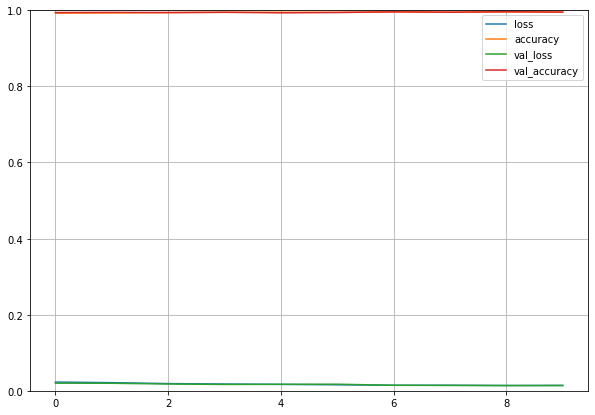

In [24]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [25]:
test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size=(128,128),
                 batch_size=20,
                 class_mode='binary')



Found 992 images belonging to 2 classes.


In [75]:
#Evaluating on test dataset images 
fcnn_1.evaluate(test_generator, steps=50)

50/50 [==============================] - 102s 2s/step - loss: 0.0113 - accuracy: 0.9980


[0.011325175873935223, 0.9979838728904724]